# Interpreting SVHN Training with SGDNoise

The gradient noise of SGD is considered crucial to the generalization performaces of deep learning models. However, in SGDNoise, authors propose that "noises in classes different from the SGD noise can also effectively regularize gradient descent." This notebook trains a VGG11 model using small SVHN dataset. Three different training methods are conducted: Stochastic Gradient Descenet (SGD), Gradient Descent (GD), and Bernoulli Gradient Descent (BGD). Results show that an algorithm (for example BGD) that performs noisy gradient descent can generalize as SGD. 

In [1]:
import paddle
import paddle.fluid as fluid
import tarfile, pickle, itertools
import paddle.fluid.dygraph.nn as nn
import random
import gzip
from struct import unpack
import numpy as np
import os

If you haven't done so, please first download the cropped SVHN training [dataset](http://ufldl.stanford.edu/housenumbers/train_32x32.mat) and [testing](http://ufldl.stanford.edu/housenumbers/test_32x32.mat) dataset.

SVHN is a real-world image dataset for Street View House Numbers. 

In [2]:
import scipy.io as sio
import os

def svhn(data_dir='./'):
    print('loading SVHN dataset ......')
    data = []
    trainset = sio.loadmat(os.path.join(data_dir, 'train_32x32.mat'))
    images = trainset['X'].transpose([3,2,0,1])
    labels = trainset['y'].reshape(-1,1)
    labels = labels - 1
    data.append((images[0:70000], labels[0:70000]))
    
    testset = sio.loadmat(os.path.join(data_dir, 'test_32x32.mat'))
    images = testset['X'].transpose([3,2,0,1])
    labels = testset['y'].reshape(-1,1)
    labels = labels - 1
    data.append((images[0:25000], labels[0:25000]))
    return tuple(data)

Define a VGG11 architecture for Small SVHN dataset.

In [3]:
from paddle.fluid.layer_helper import LayerHelper
from paddle.fluid.dygraph.nn import Conv2D, Pool2D, BatchNorm, Linear
from paddle.fluid.dygraph.base import to_variable

class vgg_block(fluid.dygraph.Layer):
    def __init__(self, name_scope, num_convs, in_channels, out_channels):
        super(vgg_block, self).__init__(name_scope)
        self.conv_list = []
        for i in range(num_convs):
            conv_layer = self.add_sublayer('conv_' + str(i), Conv2D(num_channels=in_channels, 
                                        num_filters=out_channels, filter_size=3, padding=1, act='relu'))
            self.conv_list.append(conv_layer)
            in_channels = out_channels
        self.pool = Pool2D(pool_stride=2, pool_size = 2, pool_type='max')
    def forward(self, x):
        for item in self.conv_list:
            x = item(x)
        return self.pool(x)
    
class VGG11(fluid.dygraph.Layer):
    def __init__(self, conv_arch=((1, 64), 
                                (1, 128), (2, 256), (2, 512), (2, 512))):
        super(VGG11, self).__init__()
        self.vgg_blocks=[]
        iter_id = 0
        in_channels = [3, 64, 128, 256, 512, 512]
        for (num_convs, num_channels) in conv_arch:
            block = self.add_sublayer('block_' + str(iter_id), 
                    vgg_block(self.full_name(), num_convs, in_channels=in_channels[iter_id], 
                              out_channels=num_channels))
            self.vgg_blocks.append(block)
            iter_id += 1
        self.fc1 = Linear(input_dim=512, output_dim=512,
                      act='relu')
        self.drop1_ratio = 0.5
        self.fc2= Linear(input_dim=512, output_dim=512,
                      act='relu')
        self.drop2_ratio = 0.5
        self.fc3 = Linear(input_dim=512, output_dim=10)
    def forward(self, x, y=None):
        for item in self.vgg_blocks:
            x = item(x)
        x = fluid.layers.reshape(x, [x.shape[0], -1])
        x = fluid.layers.dropout(self.fc1(x), self.drop1_ratio)
        x = fluid.layers.dropout(self.fc2(x), self.drop2_ratio)
        x = self.fc3(x)
        return x

Define the dataloader, in which images are scaled to [0,1].

In [4]:
def data_loader(data, batch_size=100, shuffle=False):
    images = data[0].astype('float32') / 255.0
    labels = data[1].astype('int64')
    assert images.shape[0] == labels.shape[0], \
        'length of images({}) should be the same as labels({})'.format(images.shape[0], labels.shape[0])
    data_ids = list(range(labels.shape[0]))

    def generator():
        if shuffle:
            random.shuffle(data_ids)
        batch_image, batch_label = [], []
        for i in data_ids:
            batch_image.append(images[i])
            batch_label.append(labels[i])
            if len(batch_label) == batch_size:
                yield np.array(batch_image), np.array(batch_label)
                batch_image, batch_label = [], []
        if len(batch_label) > 0:
            yield np.array(batch_image), np.array(batch_label)

    return generator

To reduce the training time, 25000 images from the original test set are used as the training set, and 70000 images from the original training set are used as the test set.

In [5]:
test_dataset, train_dataset = svhn()
train_loader = data_loader(train_dataset, batch_size=100, shuffle=True)
test_loader = data_loader(test_dataset, batch_size=100, shuffle=False)

loading SVHN dataset ......


Here we self-defined a loss function that apply masks to cross entropy loss.

In [6]:
def CEwithMask(input, target, mask=None):
    """mask should have identity mean"""
    input = fluid.layers.log_softmax(input, axis=-1)
    onehot_target = fluid.layers.one_hot(target, 10)
    loss = fluid.layers.elementwise_mul(input, onehot_target)
    loss = - fluid.layers.reduce_sum(loss, dim=1, keep_dim=True)#- input[]
    if mask is not None:
        loss = loss * mask
    loss = fluid.layers.mean(loss)
    return loss

Define the trainer and tester.

In [24]:
def tester(model, data_loader, place=fluid.CPUPlace()):
    model.eval()
    correct, total = 0, 0
    with fluid.dygraph.guard(place), fluid.dygraph.no_grad():
        for batch_id, (batch_image, batch_label) in enumerate(data_loader(), 1):
            batch_image = fluid.dygraph.to_variable(batch_image)
            batch_label = fluid.dygraph.to_variable(batch_label.reshape(-1,))
            predict = fluid.layers.argmax(model(batch_image), axis=1)
            correct += fluid.layers.reduce_sum(fluid.layers.equal(predict, batch_label).astype('int32')).numpy()[0]
            total += batch_label.shape[0]
    return correct / total


def trainer(train_type, iterations=10000, lr=0.05, batch_size=100, no_cuda=False, test_iter=10):
    if no_cuda:
        place = fluid.CPUPlace()
    else:
        place = fluid.CUDAPlace(0)
    
    test_accuracy = list()
    iter = 0
    with fluid.dygraph.guard(place):
        model = VGG11()
        model.train()

        n_batches = np.ceil(train_dataset[0].shape[0] / batch_size)
        optimizer = fluid.optimizer.SGDOptimizer(learning_rate=lr, parameter_list=model.parameters())
        
        if train_type == 'sgd':
            epochs = int(iterations // n_batches)
        elif train_type == 'gd' or train_type == 'bgd':
            epochs = iterations
        
        prob = 1 / n_batches
        best_acc = 0
        for epoch_id in range(1, epochs + 1):
            l_total = None
            total_loss = 0
            if train_type == 'gd' or train_type == 'bgd':
                model.clear_gradients()
            for batch_id, (batch_image, batch_label) in enumerate(train_loader(), 1):
                batch_image = fluid.dygraph.to_variable(batch_image)
                batch_label = fluid.dygraph.to_variable(batch_label)
                
                predict = model(batch_image, batch_label)
                
                if train_type == 'sgd':
                    avg_loss = CEwithMask(predict, batch_label, mask=None)
                    model.clear_gradients()
                    avg_loss.backward()
                    
                    if iter % test_iter == 0:
                        accuracy = tester(model, test_loader, place)
                        print(accuracy)
                        test_accuracy.append((accuracy, iter))
                        model.train()
                    iter += 1
                    
                elif train_type == 'gd':
                    avg_loss = CEwithMask(predict, batch_label, mask=None) 
                    if batch_id % 100 == 0:
                        print('loss', avg_loss.numpy()[0])
                    avg_loss.backward()
                    l = optimizer.backward(avg_loss, parameter_list = None)

                    if l_total is None:
                        l_total = [(tup[0], tup[1]/n_batches) for tup in l]
                    else:
                        for i, param in enumerate(l):
                            l_total[i] = (l_total[i][0], l_total[i][1] + l[i][1]/n_batches)
                            
                elif train_type == 'bgd':
                    mask = fluid.layers.uniform_random(batch_label.shape, dtype="float32")
                    mask = fluid.layers.cast(mask > 1-prob, dtype='float32')
                    mask *= n_batches
                    
                    avg_loss = CEwithMask(predict, batch_label, mask=mask)
                    print('loss', avg_loss.numpy()[0])
                    
                    avg_loss.backward()
                    l = optimizer.backward(avg_loss, parameter_list = None)
                    
                    if l_total is None:
                        l_total = [(tup[0], tup[1]/n_batches) for tup in l]
                    else:
                        for i, param in enumerate(l):
                            l_total[i] = (l_total[i][0], l_total[i][1] + l[i][1]/n_batches)
                    
                if train_type == 'sgd':
                    optimizer.minimize(avg_loss)
                    
            if train_type == 'gd' or train_type == 'bgd':
                optimizer.apply_gradients(l_total)
                if iter % test_iter == 0:
                    accuracy = tester(model, test_loader, place)
                    print(accuracy)
                    test_accuracy.append((accuracy, iter))
                    model.train()
                iter += 1

    test_accuracy = np.array(test_accuracy)
    return test_accuracy

In [16]:
sgd_accuracies = trainer(train_type='sgd', iterations=15000, lr=0.05, batch_size=100, no_cuda=False, test_iter=10)

In [26]:
gd_accuracies = trainer(train_type='gd', iterations=15000, lr=0.05, batch_size=100, no_cuda=False, test_iter=1)

In [3]:
bgd_accuracies = trainer(train_type='bgd', iterations=15000, lr=0.05, batch_size=100, no_cuda=False, test_iter=10)

In the cells below, we print the best test accuracies and plot testing accuracies for three training procedures. We observe that the best accuracies for SGD and BGD are close, and both are better than GD. 

In [24]:
print('Best SGD Testing Accuracy:', max([tup[0] for tup in sgd_accuracies]))
print('Best GD Testing Accuracy:', max([tup[0] for tup in gd_accuracies]))
print('Best BGD Testing Accuracy:', max([tup[0] for tup in bgd_accuracies]))

Best SGD Testing Accuracy: 0.8726285714285714
Best GD Testing Accuracy: 0.8474428571428572
Best BGD Testing Accuracy: 0.8690857142857142


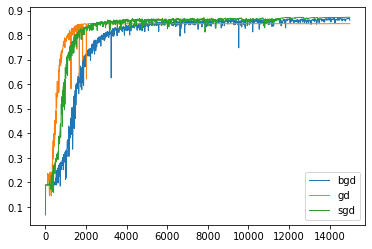

In [20]:
import matplotlib.pyplot as plt
plt.plot(np.arange(0, 15000, 10), [tup[0] for tup in bgd_accuracies], linewidth=1, label = 'bgd')
plt.plot(np.arange(0, 15000, 10), [tup[0] for tup in gd_accuracies], linewidth=1,label = 'gd')
plt.plot(np.arange(0, 15000, 10), [tup[0] for tup in sgd_accuracies],  linewidth=1,label = 'sgd')
plt.legend()

In [16]:
import numpy as np
bgd = np.load('bgd_svhn_sgd.npy')[:15000]
gd = np.load('gd_svhn_sgd.npy')[:15000]
sgd = np.load('sgd_svhn_sgd.npy')[:15000]
print(max([tup[0] for tup in bgd]))
print(max([tup[0] for tup in gd]))
print(max([tup[0] for tup in sgd]))

0.8690857142857142
0.8474428571428572
0.8726285714285714


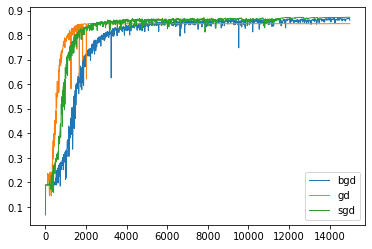

In [19]:
import matplotlib.pyplot as plt
plt.plot(np.arange(0, 15000, 10), [tup[0] for i, tup in enumerate(bgd) if i % 10 == 0], linewidth=1, label = 'bgd')
plt.plot(np.arange(0, 15000, 10), [tup[0] for i, tup in enumerate(gd) if i % 10 == 0], linewidth=1,label = 'gd')
plt.plot(np.arange(0, 15000, 10), [tup[0] for i, tup in enumerate(sgd) if i % 10 == 0],  linewidth=1,label = 'sgd')
plt.legend()